# Few short learning with Siamese Networks

In [1]:
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8) #0.333
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



In [2]:
from tensorflow.compat.v1.keras import backend as K
import tensorflow as tf
K.clear_session()
tf.compat.v1.reset_default_graph()
K.get_session()

In [3]:
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')
import cv2
import os
from skimage import io
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
#from fr_utils import *
#from inception_blocks_v2 import *
import numpy.random as rng
from sklearn.utils import shuffle

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

np.set_printoptions(threshold=sys.maxsize)

In [4]:
# Check whether GPU is being or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16167392688611808071
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9370284851
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12537655040364990713
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
#check the GPU again
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  1
2.4.0


'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [6]:
data_path = os.path.join('/home/sina/Desktop/omniglot')
train_folder = os.path.join(data_path,'images_background')
valpath = os.path.join(data_path,'images_evaluation')

In [7]:
base_class_name = 'character'

In [8]:
img = cv2.imread('/home/sina/Desktop/omniglot/images_evaluation/Aurek-Besh/character16/1052_16.png')
print("Each image in the data set has a same of {0}".format(img.shape))
flattened_img = img.flatten()

print("The number of features in any image from the data set are: {0}".format(flattened_img.shape[0]))

Each image in the data set has a same of (105, 105, 3)
The number of features in any image from the data set are: 33075


In [9]:
def gen_class_names(base_class_name):
    classes = []
    for i in range(1,21):
        if i < 10:
            classes.append("{0}0{1}".format(base_class_name, i))
        else:
            classes.append("{0}{1}".format(base_class_name, i))
    return classes

In [10]:
classes = gen_class_names(base_class_name)

In [11]:
def generate_one_hot_encoding(classes):
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

In [12]:
labels = generate_one_hot_encoding(classes)

In [13]:
def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

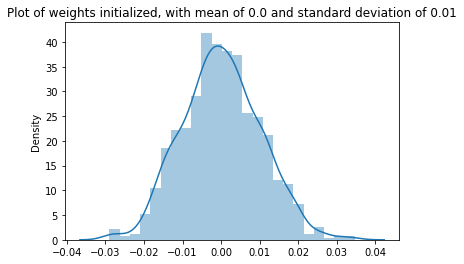

In [14]:
from matplotlib import pyplot as plt

# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

In [15]:
def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

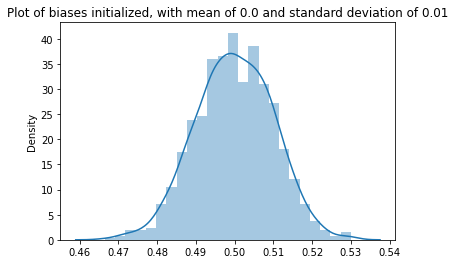

In [16]:
# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [17]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [18]:
model = get_siamese_model((105, 105, 1))
#model = get_siamese_model((224,224,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[0][0]             

### Optimizing function and loss function
The training was initially done using Stochastic gradient descent(as described in the paper) with a learning rate 0.0005(choosen randomly between 0.01 and 0.00001) initially, due to which the convergence of model was very slow, after 3000 iterations the validation decreased from .47 to .43, where when the training was done using Adam's algorithm to optimize the training process even though with a smaller learning rate of 0.00006, the decrease in the validation loss was much faster as compared to simple Stochastic Gradient Descent.



In [19]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

### Image Verification and Recognition



## Dataset

In [20]:
def plot_images(path):
    """
        Plot all 20 samples of a particular character of a language
    """
    f, axarr = plt.subplots(5,4, figsize=(10,10))
    images_list = []
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        img = cv2.imread(image_path)
        images_list.append(img)
    for i in range(5):
        for j in range(4):
            axarr[i,j].imshow(images_list.pop())

Arcadian language, 20 samples of the third character.


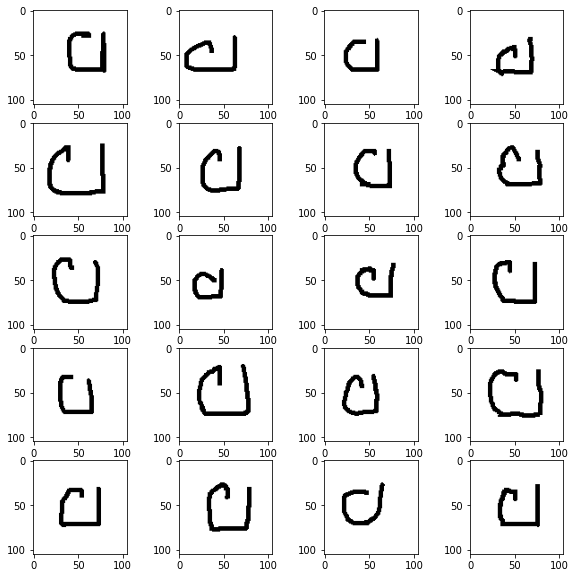

In [21]:
plot_images(os.path.join(data_path, 'images_evaluation/Aurek-Besh/character16'))
print("Arcadian language, 20 samples of the third character.")

Korean language, 20 samples of the seventh character.


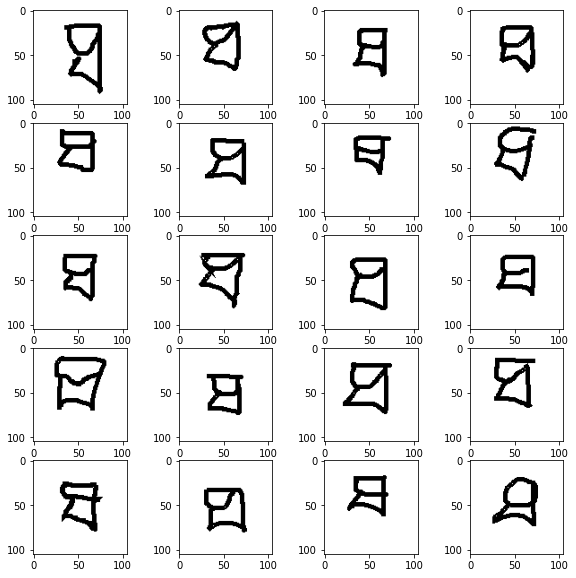

In [22]:
plot_images(os.path.join(data_path, 'images_evaluation/Tibetan/character16'))
print("Korean language, 20 samples of the seventh character.")

In [23]:
from load_data import *

loading alphabet: Braille
loading alphabet: Balinese
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Futurama
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Armenian
loading alphabet: Cyrillic
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Hebrew
loading alphabet: Early_Aramaic
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Korean
loading alphabet: Arcadian
loading alphabet: Japanese_(katakana)
loading alphabet: Latin
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Burmese_(Myanmar)
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: N_Ko
loading alphabet: Bengali
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Tifinagh
loading alphabet: Japanese_(hiragana)
loading alphabet: Grantha
loading alphabet: Sanskrit
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Tagalog
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Mkhedruli_(Georgian)
loa

### Data Pre-processing

In [25]:
save_path = '/home/sina/Desktop/data/'

with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (X, classes) = pickle.load(f)

with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(classes.keys()))
print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Training alphabets: 

['Braille', 'Balinese', 'Anglo-Saxon_Futhorc', 'Futurama', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Armenian', 'Cyrillic', 'Malay_(Jawi_-_Arabic)', 'Hebrew', 'Early_Aramaic', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Korean', 'Arcadian', 'Japanese_(katakana)', 'Latin', 'Syriac_(Estrangelo)', 'Burmese_(Myanmar)', 'Greek', 'Gujarati', 'N_Ko', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Tifinagh', 'Japanese_(hiragana)', 'Grantha', 'Sanskrit', 'Asomtavruli_(Georgian)', 'Tagalog', 'Alphabet_of_the_Magi', 'Mkhedruli_(Georgian)']
Validation alphabets:

['Braille', 'Balinese', 'Anglo-Saxon_Futhorc', 'Futurama', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Armenian', 'Cyrillic', 'Malay_(Jawi_-_Arabic)', 'Hebrew', 'Early_Aramaic', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Korean', 'Arcadian', 'Japanese_(katakana)', 'Latin', 'Syriac_(Estrangelo)', 'Burmese_(Myanmar)', 'Greek', 'Gujarati', 'N_Ko', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'T

### Training pipeline

In [27]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))
    

loader = Siamese_Loader(save_path)

loading data from /home/sina/Desktop/data/train.pickle
loading data from /home/sina/Desktop/data/val.pickle


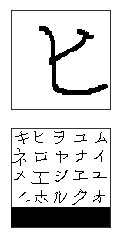

In [28]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)

In [ ]:
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 12000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1
weights_path_2 = os.path.join(data_path, "model_weights.h5")

print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=model.train_on_batch(inputs,targets)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss)) 
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = loader.test_oneshot(model,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            #print("Saving weights to: {0} \n".format(weights_path))
            model.save_weights(weights_path_2)
            best=val_acc
    
    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

        
model.load_weights(weights_path_2)

### Testing pipeline 

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 30, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(model, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(model, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20, "val")
plt.show()

plot_oneshot_task(inputs)

### Inference and Observations

The above model created seems to overfit a bit, one of the main reasons can be, the learning decay for each layer(as it is being mentioned in the original paper), has not been implemented in the current notebook.

Also one of the other reasons can be, is number of iterations during training time. Currently the model is being trained for 20,0000 iterations, one iteration being one full pass over the data set.

**Metric used to test the efficiency of the model**
Siamese Networks are mainly used to Image Verification.

Image Verification, being the task you're given two images and you have to tell if they are of the same person/class or category. Since in context of the problem we have in hand of image verification, classifying similar images of characters as same is the main problem we need to solve, therefore choosing ***accuracy*** is the right metric we should use to validate the performance of our model on new unseen data.